This notebook attempts to look at the different ways we could forecast COVID-19 cases and their efficacy.

We start by taking the original dataset resampled to give the number of new cases per day. 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/daily.csv')

In [4]:
df.head()

,Unnamed: 0,date_dt,cases,7_day_avg,ds,y
0,0,2020-02-27,1,NaN,2020-02-27,1
1,1,2020-02-28,0,NaN,2020-02-28,0
2,2,2020-02-29,0,NaN,2020-02-29,0
3,3,2020-03-01,0,NaN,2020-03-01,0
4,4,2020-03-02,0,NaN,2020-03-02,0


In [5]:
df['date'] = pd.to_datetime(df['date_dt'])

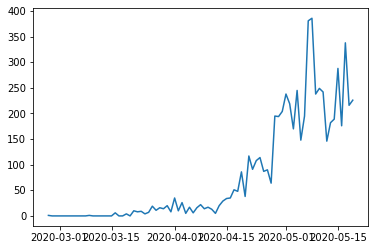

In [6]:
plt.plot(df['date'], df['cases'])

Let's see how FB prophet does at predicting the last 7 days worth of data.

In [7]:
# Try and predict based on data until 27/05/2020
# Try FB prophet for forecasting
from fbprophet import Prophet

# Get the data into somethening prophet can understand
df['ds'] = df['date']
df['y'] = df['cases']

In [8]:
m = Prophet()
m.fit(df[df['date'] <= '2020-05-13'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
79,2020-05-16
80,2020-05-17
81,2020-05-18
82,2020-05-19
83,2020-05-20


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
79,2020-05-16,265.879912,216.870884,313.712968
80,2020-05-17,269.107427,224.396797,317.887412
81,2020-05-18,273.152709,224.979616,323.081197
82,2020-05-19,277.197532,233.685882,324.671321
83,2020-05-20,288.969612,241.560218,335.302053


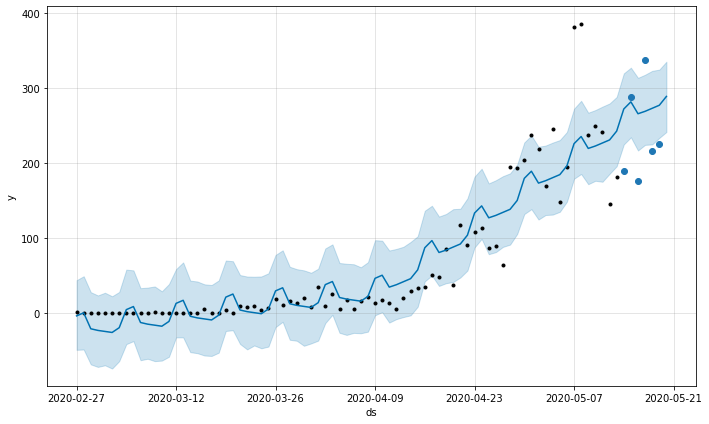

In [11]:
fig1 = m.plot(forecast)
y = df[df['date'] > '2020-05-13']
plt.scatter(y['date'], y['cases'])

It's OK, but it would be useful to have some sort of metric, let's see what the Mean Average Error and RMSE look like. 

In [12]:
def calc_mae(predictions, targets):
    return np.sum(np.abs(predictions.values - targets.values))/ len(predictions)

def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions.values-targets.values)**2))

predictions = forecast['yhat'][-6:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')

RMSE error: 70.33
MAE error: 66.16


So the error is not great, it seems to miss off the flattening of the curve, how about for the month of May.

In [13]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-01'])
future = m.make_future_dataframe(periods=19)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


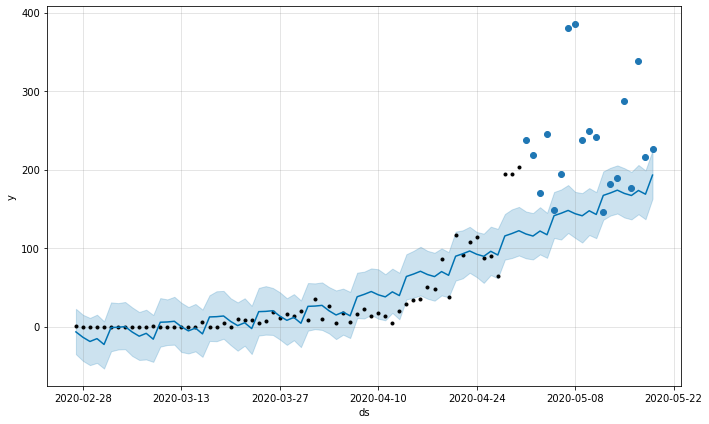

In [14]:
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['cases'])

Doesn't look great, but the data is quite noisy. How does it compare to the 7 day average.

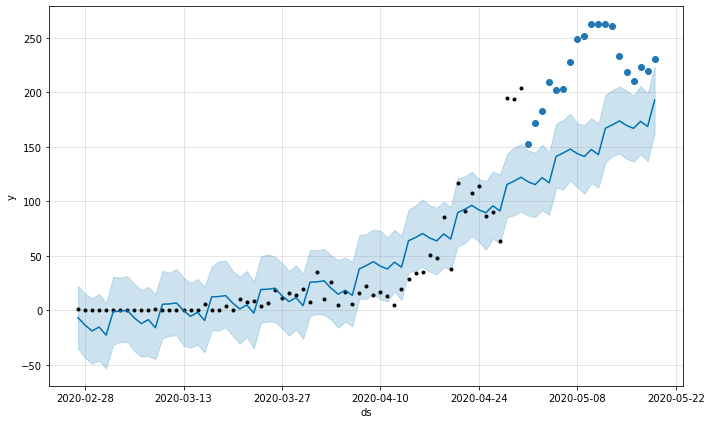

In [15]:
df['7_day_average'] = df.cases.rolling(window=7).mean()
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['7_day_average'])

In [16]:
predictions = forecast['yhat'][-19:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')


RMSE error: 110.99
MAE error: 86.81


Interestingly the RMSE is much worse - punished by the large outliers, whilst the MAE is better due to some very close predictions. 

What happens if we train it on the 7 day rolling data. 

In [17]:
df['y'] = df['7_day_average']

In [18]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-01'].dropna())
future = m.make_future_dataframe(periods=19)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


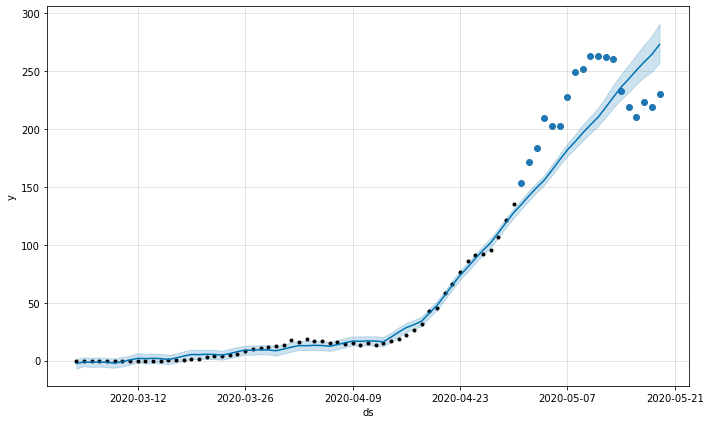

In [19]:
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['7_day_average'])

In [20]:
predictions = forecast['yhat'][-19:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = np.sum(np.abs(predictions - targets))/ len(predictions)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')

RMSE error: 84.86
MAE error: 40.82


Whilst the errors are much worse it could be argued that qualitively the graph has captured the overall trend more closely. 

What if we limit the prediction to 7 days, still using the 7 day average. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
RMSE error: 109.30
MAE error: 96.87


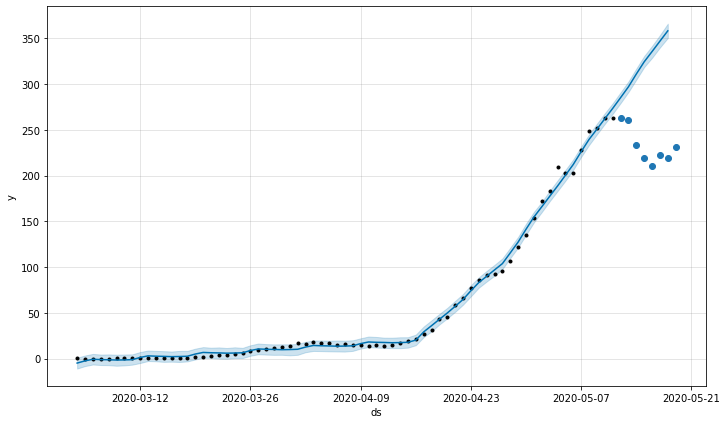

In [21]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-12'].dropna())
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-12']
plt.scatter(y['date'], y['7_day_average'])

predictions = forecast['yhat'][-8:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')


So in general FB prophet is might capture a general trend but is not great, especially with the limited data we have.

Let's take an expanded data set. 

In [22]:
df = pd.read_csv('./data/nigeria-cases.csv')

In [23]:
df.head()

,Unnamed: 0,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,58813,2020-01-03,NG,Nigeria,AFRO,0,0,0,0
1,58814,2020-01-04,NG,Nigeria,AFRO,0,0,0,0
2,58815,2020-01-05,NG,Nigeria,AFRO,0,0,0,0
3,58816,2020-01-06,NG,Nigeria,AFRO,0,0,0,0
4,58817,2020-01-07,NG,Nigeria,AFRO,0,0,0,0


In [24]:
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df['7_day_average'] = df.New_cases.rolling(window=7).mean()

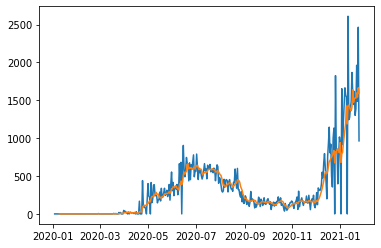

In [25]:
plt.plot(df['Date_reported'], df['New_cases'])
plt.plot(df['Date_reported'], df['7_day_average'])

In [26]:
from fbprophet.diagnostics import cross_validation
df['ds'] = df['Date_reported']
df['y'] = df['New_cases']
m = Prophet()
m.fit(df)
cv = cross_validation(m,  horizon = '7 days', period='7 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 52 forecasts with cutoffs between 2020-01-27 00:00:00 and 2021-01-18 00:00:00


  0%|          | 0/52 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [27]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days,28443.170292,168.651031,104.586525,NaN,0.711538
1,2 days,48414.470059,220.032884,131.058627,NaN,0.576923
2,3 days,66485.821681,257.848447,152.640224,NaN,0.423077
3,4 days,82510.118505,287.245746,180.570714,NaN,0.461538
4,5 days,120710.644733,347.434375,204.662118,NaN,0.423077


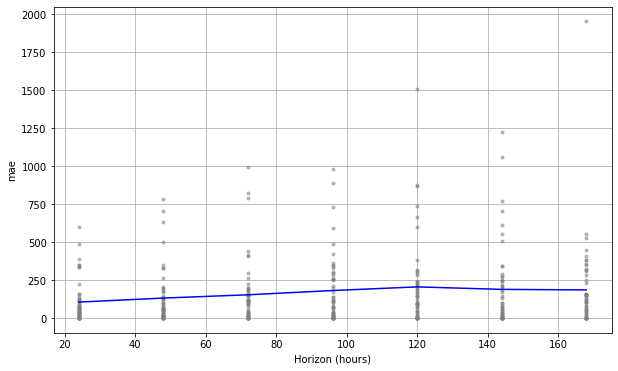

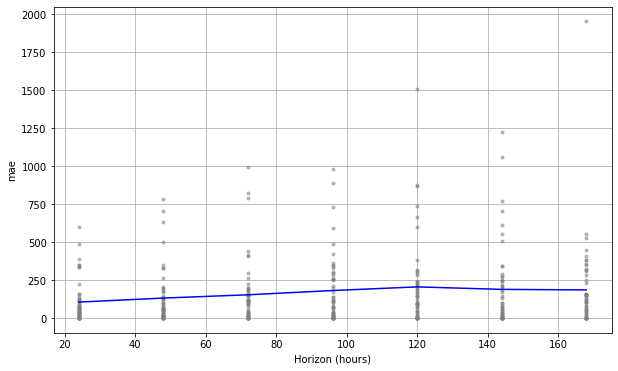

In [28]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv, metric='mae')


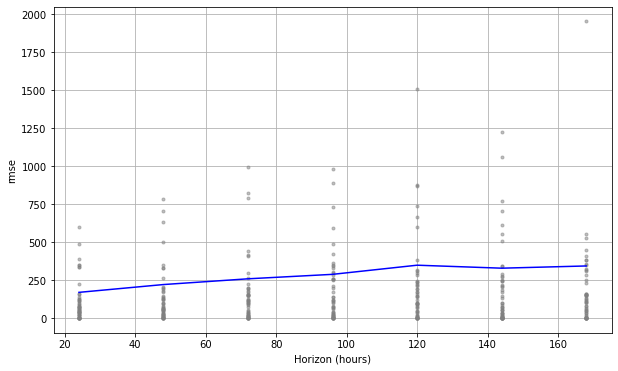

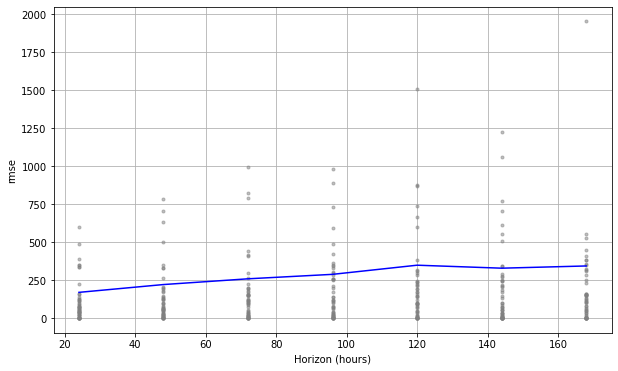

In [29]:
plot_cross_validation_metric(cv, metric='rmse')

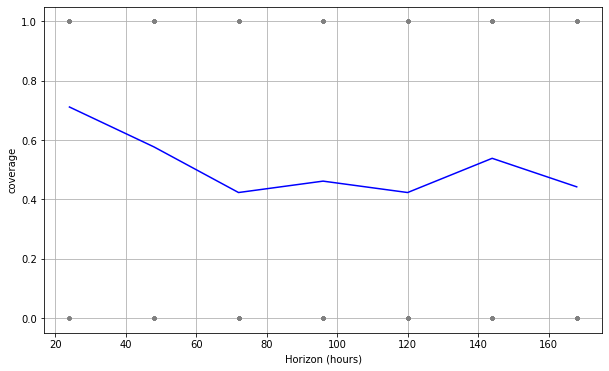

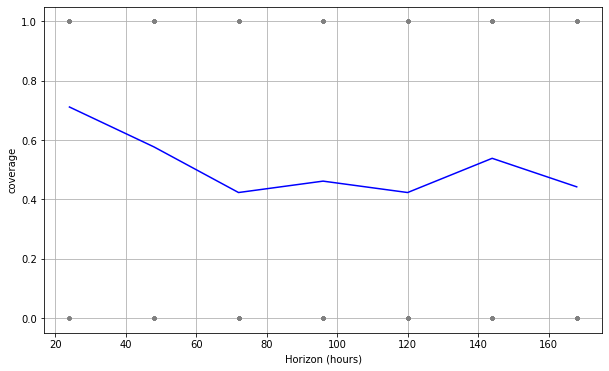

In [30]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv, metric='coverage')


In [31]:
from fbprophet.diagnostics import cross_validation
df['ds'] = df['Date_reported']
df['y'] = df['New_cases']
m = Prophet()
m.fit(df)
cv = cross_validation(m,  horizon = '30 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-04-15 00:00:00 and 2020-12-26 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

In [32]:
df_p = performance_metrics(cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,45949.665831,214.358732,166.975730,0.585683,0.351852
1,4 days,29583.331034,171.998055,138.412814,0.622232,0.425926
2,5 days,39047.800645,197.605164,153.670629,0.588305,0.425926
3,6 days,54205.606508,232.820975,167.236448,0.570070,0.425926
4,7 days,79139.873435,281.318100,192.260570,0.592005,0.388889


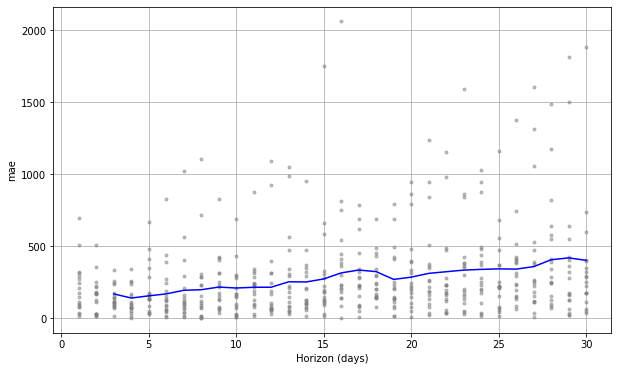

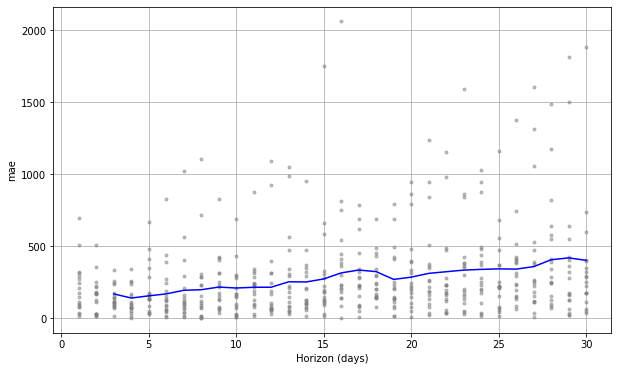

In [33]:
plot_cross_validation_metric(cv, metric='mae')

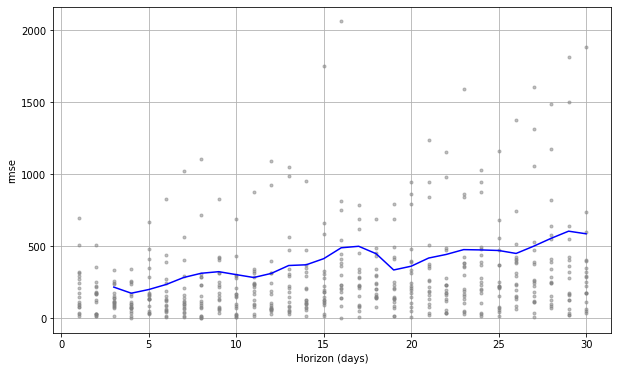

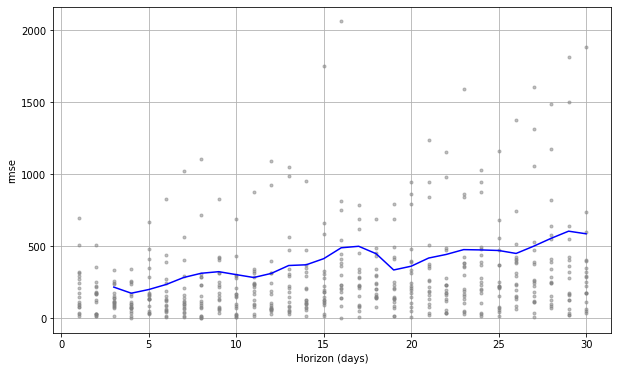

In [34]:
plot_cross_validation_metric(cv, metric='rmse')

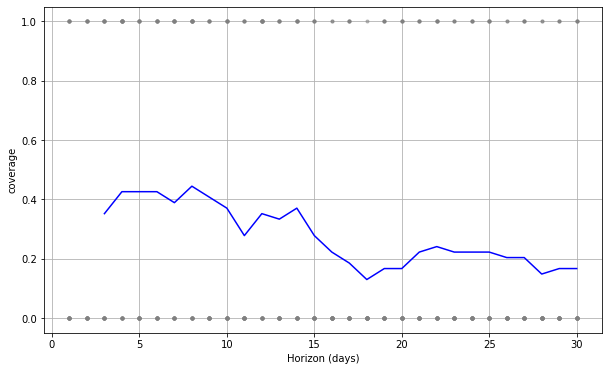

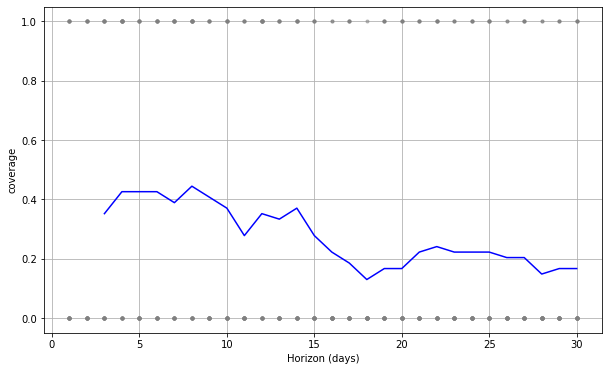

In [35]:
plot_cross_validation_metric(cv, metric='coverage')

Unsurprisingly even training over the whole dataset Prohpet is unable to get good results, likely due to the inherent randomness of the disease spread, at bese it may give you a good idea of the next days results, but is not helpful for looking at long term (7 days or more) trends. Given Prophet is more for data that shows some sort of seasonality this is not surprising. 

Prophet is an additive regression model, a more sophisticated Neural Network might yield better results. 


In [36]:
import tensorflow as tf

In [37]:
df = df[['y']]

In [38]:
df.head()

,y
0,0
1,0
2,0
3,0
4,0


In [39]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


num_features = df.shape[1]

In [40]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [41]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    

In [42]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [49]:
def plot(self, model=None, plot_col='y', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot

In [50]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [51]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [52]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


OUT_STEPS=7
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30]
Label column name(s): None

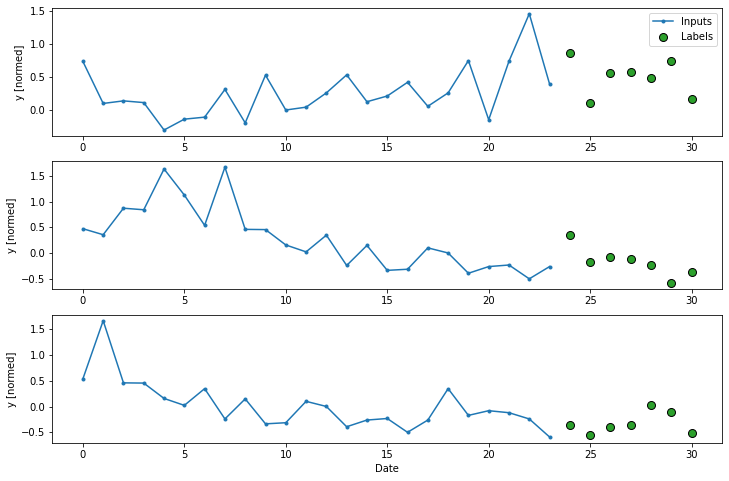

In [53]:

multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [54]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [56]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/20
8/8 [==============================] - 2s 67ms/step - loss: 0.1772 - mean_absolute_error: 0.2700 - val_loss: 0.3136 - val_mean_absolute_error: 0.3894
Epoch 2/20
8/8 [==============================] - 0s 20ms/step - loss: 0.2054 - mean_absolute_error: 0.2961 - val_loss: 0.3154 - val_mean_absolute_error: 0.3897
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3153 - mean_absolute_error: 0.3902


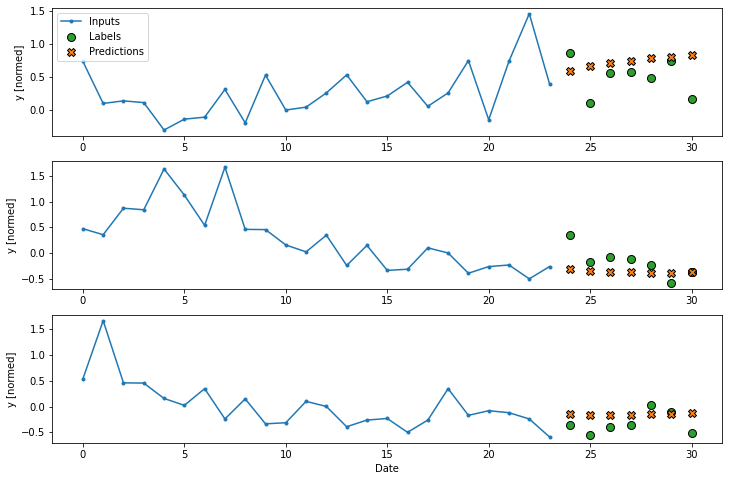

In [60]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance = {}
multi_performance = {}
# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/20
8/8 [==============================] - 1s 31ms/step - loss: 1.0660 - mean_absolute_error: 0.8901 - val_loss: 0.5037 - val_mean_absolute_error: 0.4922
Epoch 2/20
8/8 [==============================] - 0s 15ms/step - loss: 1.0140 - mean_absolute_error: 0.8577 - val_loss: 0.5001 - val_mean_absolute_error: 0.4919
Epoch 3/20
8/8 [==============================] - 0s 15ms/step - loss: 0.9644 - mean_absolute_error: 0.8271 - val_loss: 0.4964 - val_mean_absolute_error: 0.4918
Epoch 4/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0132 - mean_absolute_error: 0.8601 - val_loss: 0.4928 - val_mean_absolute_error: 0.4913
Epoch 5/20
8/8 [==============================] - 0s 15ms/step - loss: 0.9876 - mean_absolute_error: 0.8469 - val_loss: 0.4893 - val_mean_absolute_error: 0.4907
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.9661 - mean_absolute_error: 0.8321 - val_loss: 0.4860 - val_mean_absolute_error: 0.4900
Epoch 7/20
8/8 [==================

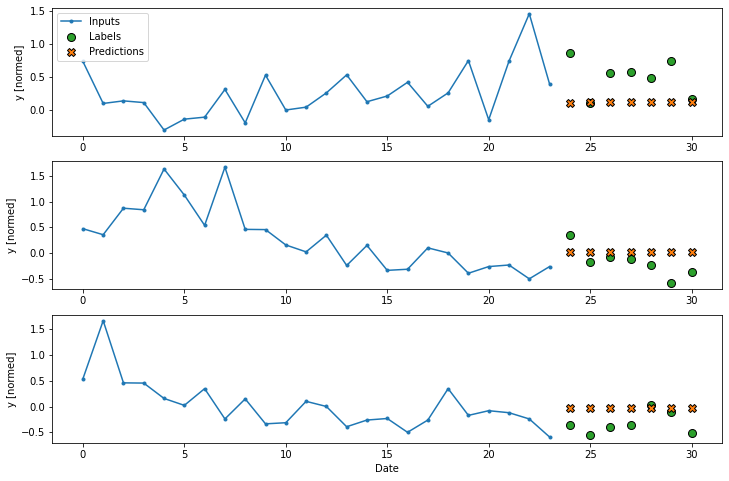

In [62]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
8/8 [==============================] - 1s 31ms/step - loss: 0.9289 - mean_absolute_error: 0.8043 - val_loss: 0.4534 - val_mean_absolute_error: 0.4633
Epoch 2/20
8/8 [==============================] - 0s 14ms/step - loss: 0.6830 - mean_absolute_error: 0.6929 - val_loss: 0.3909 - val_mean_absolute_error: 0.4182
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.5525 - mean_absolute_error: 0.6036 - val_loss: 0.3402 - val_mean_absolute_error: 0.3869
Epoch 4/20
8/8 [==============================] - 0s 14ms/step - loss: 0.3170 - mean_absolute_error: 0.4364 - val_loss: 0.3302 - val_mean_absolute_error: 0.4068
Epoch 5/20
8/8 [==============================] - 0s 15ms/step - loss: 0.2404 - mean_absolute_error: 0.3298 - val_loss: 0.3293 - val_mean_absolute_error: 0.4223
Epoch 6/20
8/8 [==============================] - 0s 15ms/step - loss: 0.3065 - mean_absolute_error: 0.3466 - val_loss: 0.3108 - val_mean_absolute_error: 0.4050
Epoch 7/20
8/8 [==================

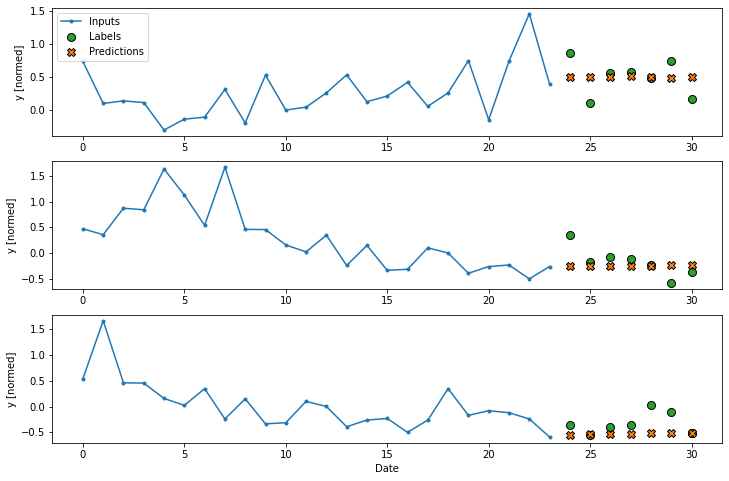

In [64]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)


multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

[0.39024725556373596, 0.47804632782936096, 0.39609917998313904]


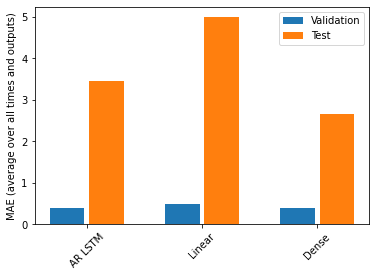

In [92]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_linear_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
print(val_mae)
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

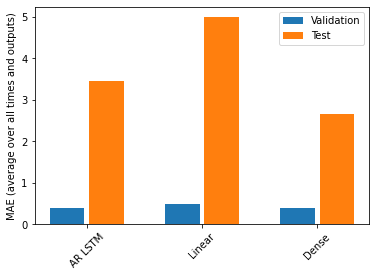

In [90]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_linear_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]


plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

[305.7172126905895, 325.98892748659443, 307.0683493230931]


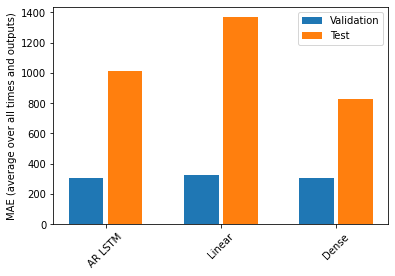

In [100]:
denormalised_val_mae = []
denormalised_test_mae = []
for x in val_mae:
    denormalised_val_mae.append(x * train_std[0] + train_mean[0])

for x in test_mae:
    denormalised_test_mae.append( x * train_std[0] + train_mean[0])

print(denormalised_val_mae)

x = np.arange(len(multi_performance))
plt.bar(x - 0.17, denormalised_val_mae, width, label='Validation')
plt.bar(x + 0.17, denormalised_test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

<AxesSubplot:>

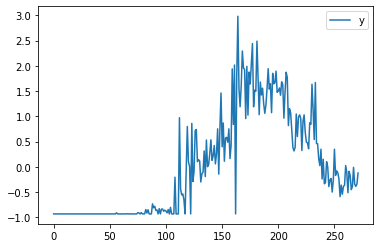

In [101]:
train_df.plot()

<AxesSubplot:>

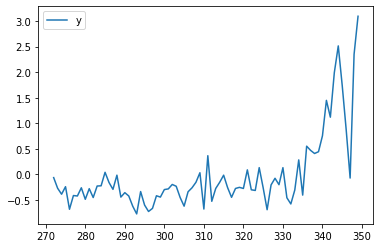

In [104]:
val_df.plot()

<AxesSubplot:>

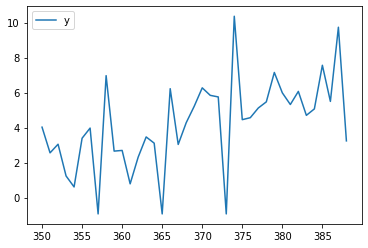

In [103]:
test_df.plot()

The data is very noisy what if we ty the same techniques applied to the 7 day average

In [113]:
df['y'] = df['y'].rolling(window=7).mean()
df.dropna(inplace=True)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [114]:
df.head()

,y
18,0.0
19,0.0
20,0.0
21,0.0
22,0.0


Epoch 1/20
8/8 [==============================] - 2s 60ms/step - loss: 0.1979 - mean_absolute_error: 0.2959 - val_loss: 0.3147 - val_mean_absolute_error: 0.3920
Epoch 2/20
8/8 [==============================] - 0s 18ms/step - loss: 0.2220 - mean_absolute_error: 0.3011 - val_loss: 0.3171 - val_mean_absolute_error: 0.3893
Epoch 3/20
8/8 [==============================] - 0s 18ms/step - loss: 0.1733 - mean_absolute_error: 0.2721 - val_loss: 0.3141 - val_mean_absolute_error: 0.3897
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 0.1942 - mean_absolute_error: 0.2767 - val_loss: 0.3148 - val_mean_absolute_error: 0.3890
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3168 - mean_absolute_error: 0.3902


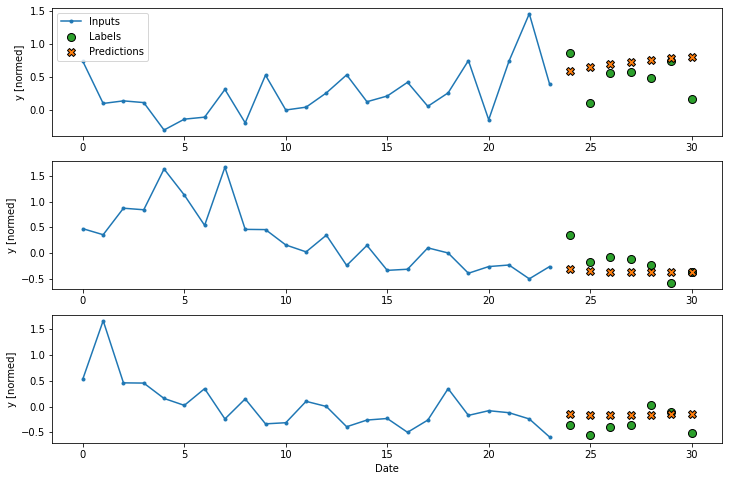

In [115]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance = {}
multi_performance = {}
# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/20
8/8 [==============================] - 0s 26ms/step - loss: 0.5460 - mean_absolute_error: 0.6287 - val_loss: 0.3923 - val_mean_absolute_error: 0.4481
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 0.6149 - mean_absolute_error: 0.6643 - val_loss: 0.3900 - val_mean_absolute_error: 0.4470
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 0.5475 - mean_absolute_error: 0.6236 - val_loss: 0.3878 - val_mean_absolute_error: 0.4453
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.5877 - mean_absolute_error: 0.6426 - val_loss: 0.3855 - val_mean_absolute_error: 0.4439
Epoch 5/20
8/8 [==============================] - 0s 13ms/step - loss: 0.5107 - mean_absolute_error: 0.6100 - val_loss: 0.3835 - val_mean_absolute_error: 0.4419
Epoch 6/20
8/8 [==============================] - 0s 12ms/step - loss: 0.5411 - mean_absolute_error: 0.6240 - val_loss: 0.3814 - val_mean_absolute_error: 0.4404
Epoch 7/20
8/8 [==================

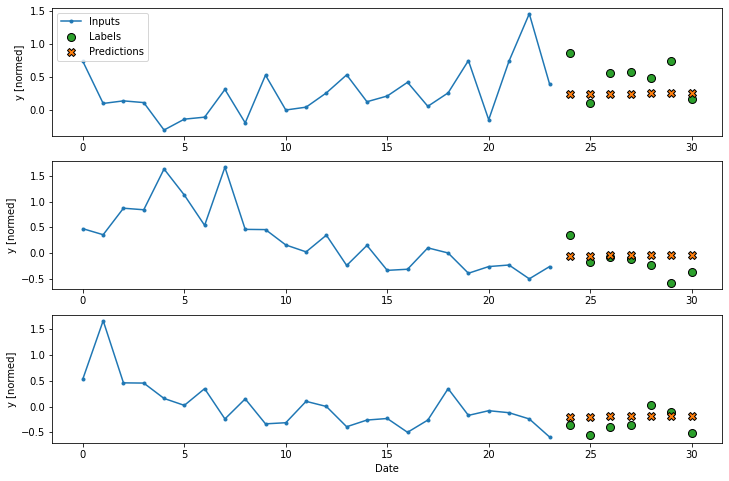

In [116]:
history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
8/8 [==============================] - 1s 30ms/step - loss: 0.2580 - mean_absolute_error: 0.3315 - val_loss: 0.3119 - val_mean_absolute_error: 0.4006
Epoch 2/20
8/8 [==============================] - 0s 12ms/step - loss: 0.2586 - mean_absolute_error: 0.3482 - val_loss: 0.3121 - val_mean_absolute_error: 0.4020
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 0.2482 - mean_absolute_error: 0.3373 - val_loss: 0.3075 - val_mean_absolute_error: 0.3981
Epoch 4/20
8/8 [==============================] - 0s 12ms/step - loss: 0.2773 - mean_absolute_error: 0.3665 - val_loss: 0.3136 - val_mean_absolute_error: 0.4004
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3157 - mean_absolute_error: 0.4025


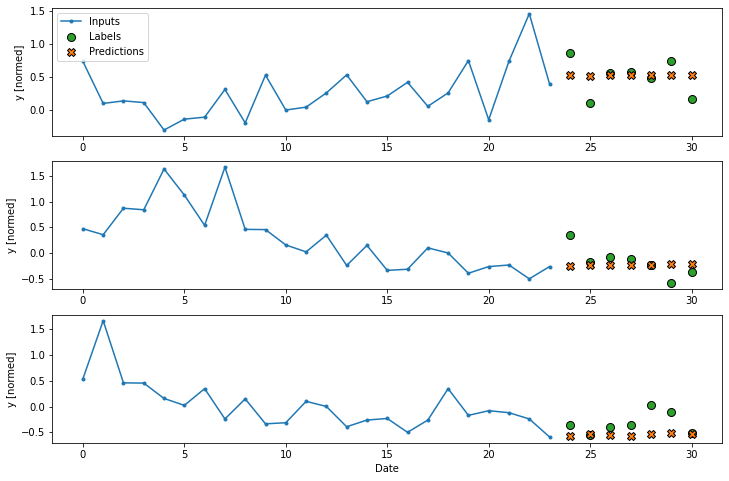

In [117]:

history = compile_and_fit(multi_dense_model, multi_window)


multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

[308.8370503073272, 327.9056932709367, 310.10800060923964]


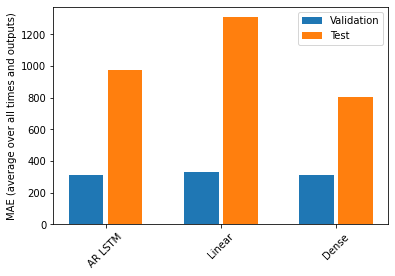

In [118]:
denormalised_val_mae = []
denormalised_test_mae = []
for x in val_mae:
    denormalised_val_mae.append(x * train_std[0] + train_mean[0])

for x in test_mae:
    denormalised_test_mae.append( x * train_std[0] + train_mean[0])

print(denormalised_val_mae)

x = np.arange(len(multi_performance))
plt.bar(x - 0.17, denormalised_val_mae, width, label='Validation')
plt.bar(x + 0.17, denormalised_test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

<AxesSubplot:>

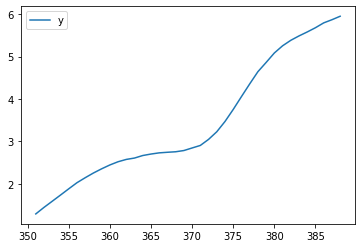

In [119]:
test_df.plot()

Whilst the scores are similar to prophet on the valdation set, the model really struggles to cope with the new mode of behaviour on the validation set. 

<AxesSubplot:>

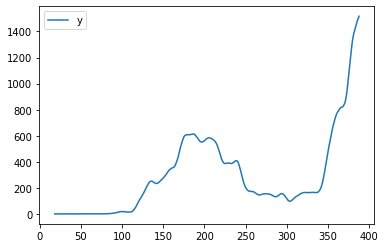

In [120]:
df.plot()

It looks like machine learning techniques are going to struggle to make predictions on the base dataset. Ideally we could feed more features into the model, possibly search terms 

In [3]:
df = pd.read_csv('data/nigeria-cases.csv')

In [5]:
df.head()

,Unnamed: 0,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,58813,2020-01-03,NG,Nigeria,AFRO,0,0,0,0
1,58814,2020-01-04,NG,Nigeria,AFRO,0,0,0,0
2,58815,2020-01-05,NG,Nigeria,AFRO,0,0,0,0
3,58816,2020-01-06,NG,Nigeria,AFRO,0,0,0,0
4,58817,2020-01-07,NG,Nigeria,AFRO,0,0,0,0


We can try and use the SEIR model to see if it can model the macro effects of the pandemic.

In [115]:
# The SIR model differential equations.
def derivSEIR(y, t, lam, alpha, gamma):
    S, E, I, R = y
    dSdt = -lam * I * S
    dEdt = lam * S * I - alpha * E
    dIdt = alpha * E - gamma * I 
    dRdt = gamma * I 
    return dSdt, dEdt, dIdt, dRdt

In [116]:
from scipy.integrate import odeint
# Parameters from "Modeling the second wave of COVID-19 infections in France and Italy via a stochastic SEIR model"
# Initial conditions 
# 300 Days
t = np.arange(1,250,1)

# Population
N = 206000000
N = 67000000
# 5 Initial infections
I0 = 1
S0 = N - I0
E0 = 0
R0 = 0
y0 = S0, E0, I0, R0
# Parameters
gamma = 0.37
alpha = 0.27
lam = 1 / S0
# Integrate the SIR equations over the time grid, t.
ret = odeint(derivSEIR, y0, t, args=(lam, alpha, gamma))
S, E, I, R = ret.T

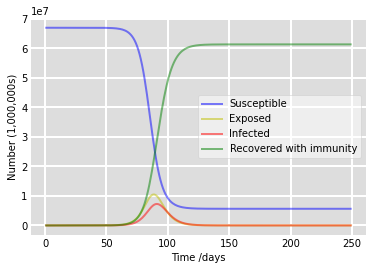

In [117]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1,000,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

It is important to note that the above graph is the total numnber of people in each category, to match the data we should represent new cases

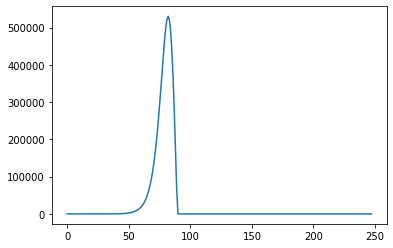

In [118]:
new_cases = []
for i in range(0, len(I) - 1):
    if I[i] < I[i+1]:
        new_cases.append(I[i+1] - I[i])
    else:
        new_cases.append(0)

plt.plot(new_cases)
    

This model much better captures the macro parameters of the epidemic over a large time scale. However there are still limitations, the pandemic only lasts 20 days in this model, vasltly overestimates the number of infections and has no second wave. 

Nigeria also went into a lockdown on March 30th which is not taken into account by the model. 

In [169]:
# The SIR model differential equations.
def derivStochasticSEIR(y, t, lam0, alpha0, gamma0):
    sigma = 0.4
    alpha = np.random.normal(alpha0, (0.2 * alpha0)**2)
    gamma = 0.37 # np.random.normal(gamma0, (0.2* gamma0)**2 )
    lam = 1 / 67000000
    print(alpha, gamma, lam)
    S, E, I, R = y
    dSdt = -lam * I * S
    dEdt = lam * S * I - alpha * E
    dIdt = alpha * E - gamma * I 
    dRdt = gamma * I 
    return dSdt, dEdt, dIdt, dRdt

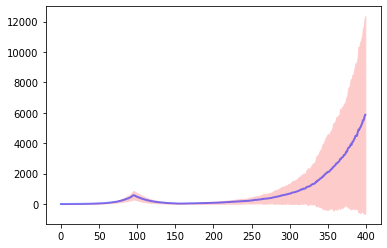

In [354]:

# Parameters from "Modeling the second wave of COVID-19 infections in France and Italy via a stochastic SEIR model"
# Initial conditions 
# 300 Days
t = np.arange(1,250,1)

# Lock down dates 04/05/2020 - 01/06/2020
# Eased over june
# Further eased over July
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7490626/#:~:text=Phases%20of%20the%20lockdown%20in%20Nigeria&text=The%20first%20phase%20of%20the,6%20am%20was%20equally%20announced.


# Population
N = 206000000
# 5 Initial infections
I0 = 1
S0 = N - I0
E0 = 0
R0 = 0
y0 = S0, E0, I0, R0
lam = 1 / S0
# Odeint doesn't like stochastic differential equations so we'll have to write our own

#PARAMETER DEFINITIONS
tmax=400
nrel=100
# tconf: lockdown day
tconf=94
# tconf2: lockdown release
tconf2=124
tconf3=154
lambdaconf = 0.2
lambdares = 0.3
lambdares2 = 0.4
Irel = np.zeros([nrel, tmax])
# Loop on realisations
for rel in range(0,nrel):
    S = np.zeros(tmax)
    E = np.zeros(tmax)
    I = np.zeros(tmax)
    R = np.zeros(tmax)
    lam = np.zeros(tmax)
    S[0] = N
    E[0] = 0
    I[0] = 5
    R[0] = 0
    alpha0=0.27
    r0 = 2.68
    gamma0 = 0.35
    coeff_gamma = 0.5
    coeff_lambda = 0.005
    lambda0 = 0.5
    orig_lambda = lambda0
    for t in range(0,tmax - 1):
        gamma = gamma0 + np.random.normal() * gamma0 / 5
        if t == tconf:
            lambda0 =  orig_lambda/2 #lambdaconf
        if t == tconf2: 
            lambda0 =  orig_lambda/2 # lambdares
        if t == tconf3: 
            lambda0 = orig_lambda - 0.1 #lambdares2
        lam_= (lambda0 + np.random.normal()*lambda0/5) / S[0]
        alpha = alpha0 + np.random.normal() * alpha0 /5 
        S[t+1] = S[t] - lam_ * S[t] * I[t]
        E[t+1] = E[t] + (lam_ * S[t] * I[t] - alpha * E[t])
        I[t+1] = I[t] + alpha * E[t] - gamma * I[t]
        R[t+1] = R[t] + gamma * I[t]
        Irel[rel,t+1] = I[t+1]


Imean = np.zeros(tmax)
Istd = np.zeros(tmax)
for i in range(0,tmax):
    Imean[i] = np.mean(Irel[:,i])
    Istd[i] = np.std(Irel[:,i])


# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
plt.plot(np.arange(0,tmax), Imean, 'r', alpha=0.5, lw=2, label='Infected', color='blue')
plt.fill_between(np.arange(0,tmax), Imean-Istd, Imean + Istd, color=[(255/256,204/256,204/256)])

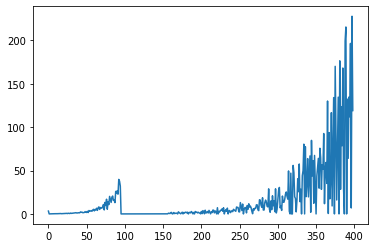

In [355]:
new_cases = []
for i in range(0, len(Imean) - 1):
    if Imean[i] < Imean[i+1]:
        new_cases.append(Imean[i+1] - Imean[i])
    else:
        new_cases.append(0)

plt.plot(new_cases)
    

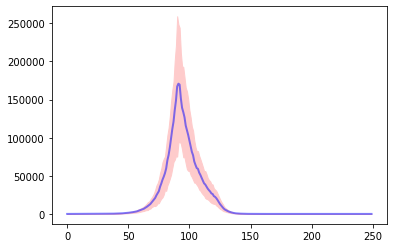

In [280]:
Imean = np.zeros(tmax)
Istd = np.zeros(tmax)
for i in range(0,tmax):
    Imean[i] = np.mean(Irel[:,i])
    Istd[i] = np.std(Irel[:,i])


# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
plt.plot(np.arange(0,tmax), Imean, 'r', alpha=0.5, lw=2, label='Infected', color='blue')
plt.fill_between(np.arange(0,tmax), Imean-Istd, Imean + Istd, color=[(255/256,204/256,204/256)])
# ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
# ax.set_xlabel('Time /days')
# ax.set_ylabel('Number (1,000,000s)')
# ax.set_ylim(0,1.2)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
    # ax.spines[spine].set_visible(False)
# plt.show()

0.0

In [305]:
df.head()

,Unnamed: 0,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,58813,2020-01-03,NG,Nigeria,AFRO,0,0,0,0
1,58814,2020-01-04,NG,Nigeria,AFRO,0,0,0,0
2,58815,2020-01-05,NG,Nigeria,AFRO,0,0,0,0
3,58816,2020-01-06,NG,Nigeria,AFRO,0,0,0,0
4,58817,2020-01-07,NG,Nigeria,AFRO,0,0,0,0


<AxesSubplot:>

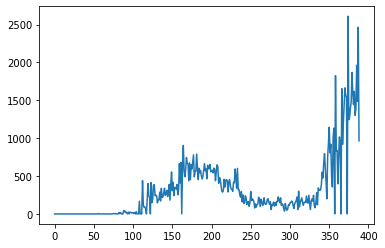

In [307]:
df['New_cases'].plot()